In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Update path to your actual file
csv_path = '/content/drive/MyDrive/airquality/AirQualityUCI.csv'

# Read the dataset (semicolon-separated, European decimals)
df = pd.read_csv(csv_path, sep=';', decimal=',', engine='python')
df = df.iloc[:, :-2]  # Drop last two unnamed columns
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [ ]:
# Replace '.' with ':' in the Time column to make it parsable
df['Time'] = df['Time'].str.replace('.', ':', regex=False)

# Now safely parse Date + Time into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')

# Drop rows where datetime parsing failed
df = df.dropna(subset=['Datetime'])

# Sort by datetime
df = df.sort_values('Datetime')

# Show a few rows to confirm
df[['Date', 'Time', 'Datetime']].head()

,Date,Time,Datetime
0,10/03/2004,18:00:00,2004-03-10 18:00:00
1,10/03/2004,19:00:00,2004-03-10 19:00:00
2,10/03/2004,20:00:00,2004-03-10 20:00:00
3,10/03/2004,21:00:00,2004-03-10 21:00:00
4,10/03/2004,22:00:00,2004-03-10 22:00:00


Select Sensor Features and Normalize

- We'll choose 6 key sensors and normalize their values to [0, 1].




In [ ]:
# Pick relevant sensor columns
sensor_cols = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# Filter the data
data = df[['Datetime'] + sensor_cols].dropna()

# Normalize sensor values column-wise
for col in sensor_cols:
    min_val, max_val = data[col].min(), data[col].max()
    data[col] = (data[col] - min_val) / (max_val - min_val)

Simulate Sensor Positions + Create (x, y, t, s) Format

- Each sensor will be assigned a fixed (x, y) coordinate (simulated here). We loop through all rows and generate samples:

In [ ]:
import numpy as np

# Fixed but random sensor positions in [0, 1] x [0, 1] square
np.random.seed(42)
sensor_positions = {col: (np.random.rand(), np.random.rand()) for col in sensor_cols}

# Create list of spatiotemporal samples
samples = []

for _, row in data.iterrows():
    timestamp = row['Datetime'].timestamp()  # convert to seconds since epoch
    for sensor in sensor_cols:
        x, y = sensor_positions[sensor]
        value = row[sensor]
        samples.append((x, y, timestamp, value))

# Convert to numpy array
S = np.array(samples)  # shape: [num_samples, 4]
print("Spatiotemporal dataset shape:", S.shape)

Spatiotemporal dataset shape: (56142, 4)


Visualize Sensor Layout

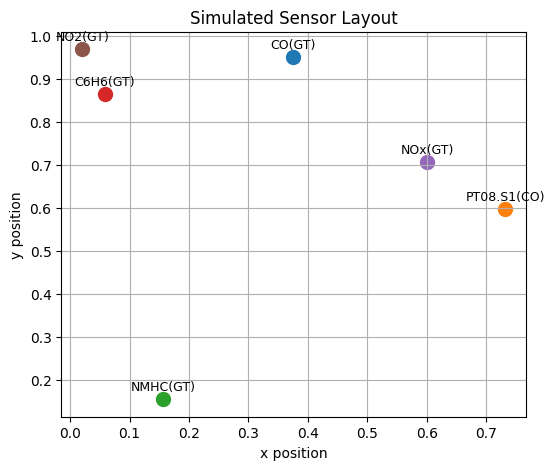

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
for sensor, (x, y) in sensor_positions.items():
    plt.scatter(x, y, s=100)
    plt.text(x, y + 0.02, sensor, ha='center', fontsize=9)

plt.title("Simulated Sensor Layout")
plt.xlabel("x position")
plt.ylabel("y position")
plt.grid(True)
plt.show()

Phase 1: Spatiotemporal Neural Field Implementation

Goal

- Train a continuous-time spatiotemporal function 𝑓_𝜃(𝑥,𝑦,𝑡)→𝑠^f using a neural field (Fourier MLP or SIREN), which learns to interpolate sensor values over space and time.

Positional Encoding (Fourier Features)
- We encode (𝑥,𝑦,𝑡) into high-frequency space to enable learning fine detail.

In [ ]:
import torch
import torch.nn as nn

class FourierEncoding(nn.Module):
    def __init__(self, in_features=3, num_frequencies=10):
        super().__init__()
        self.B = 2 ** torch.arange(num_frequencies).float() * torch.pi

    def forward(self, x):
        x_proj = x[..., None] * self.B.to(x.device)  # shape: [N, 3, F]
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1).view(x.shape[0], -1)

Define the MLP Neural Field Model

In [ ]:
class NeuralField(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, depth=4):
        super().__init__()
        layers = []

        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        for _ in range(depth - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, 1))  # Output: scalar prediction
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

Prepare Training Data

In [ ]:
# Convert to PyTorch tensors
coords = torch.tensor(S[:, :3], dtype=torch.float32)  # (x, y, t)
targets = torch.tensor(S[:, 3:], dtype=torch.float32)  # sensor value

# Normalize time to [0, 1] for better stability
coords[:, 2] = (coords[:, 2] - coords[:, 2].min()) / (coords[:, 2].max() - coords[:, 2].min())

# Apply Fourier encoding
encoder = FourierEncoding(in_features=3, num_frequencies=10)
encoded_coords = encoder(coords)  # shape: [N, 3×2×F]

print("Encoded input shape:", encoded_coords.shape)

Encoded input shape: torch.Size([56142, 60])


Training Loop

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

dataset = TensorDataset(encoded_coords, targets)
loader = DataLoader(dataset, batch_size=2048, shuffle=True)

model = NeuralField(input_dim=encoded_coords.shape[1]).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Training loop
for epoch in range(1, 201):
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {total_loss / len(loader):.6f}")

Epoch 10: Loss = 0.016252
Epoch 20: Loss = 0.010968
Epoch 30: Loss = 0.009971
Epoch 40: Loss = 0.008824
Epoch 50: Loss = 0.008223
Epoch 60: Loss = 0.007603
Epoch 70: Loss = 0.007325
Epoch 80: Loss = 0.007124
Epoch 90: Loss = 0.006976
Epoch 100: Loss = 0.006511
Epoch 110: Loss = 0.006481
Epoch 120: Loss = 0.006321
Epoch 130: Loss = 0.006160
Epoch 140: Loss = 0.005928
Epoch 150: Loss = 0.005778
Epoch 160: Loss = 0.005804
Epoch 170: Loss = 0.005509
Epoch 180: Loss = 0.005601
Epoch 190: Loss = 0.005629
Epoch 200: Loss = 0.005261


Save Model

In [ ]:
torch.save(model.state_dict(), "neural_field_model.pt")

Phase 1 Complete
- We trained a spatiotemporal neural field that maps continuous (𝑥,𝑦,𝑡) to sensor values.

- It’s ready to be visualized and logic-regularized in Phase 2.

Phase 2: Logic Rule Definition using Signal Temporal Logic (STL)



In [ ]:
!pip install "rtamt==0.9.2" --quiet

import rtamt

ERROR: Could not find a version that satisfies the requirement rtamt==0.9.2 (from versions: 0.2.5, 0.2.8, 0.3, 0.3.5)
ERROR: No matching distribution found for rtamt==0.9.2


Define a Realistic Rule

Let's write a rule like:

  - “If CO exceeds 0.6, then an alert must be triggered within the next 2 hours”

We'll simulate this as:

- Input: predicted CO levels from the model

- Output: simulated binary alert stream (just for Phase 2 testing)


Python STL Evaluator (Soft Robustness)

In [ ]:
import numpy as np

def stl_violation_score(co_signal, alert_signal, co_thresh=0.6, hold_steps=3, future_steps=2):
    """
    Compute soft STL-style violation score.

    co_signal: [T] – CO predictions
    alert_signal: [T] – binary alert stream
    """
    T = len(co_signal)
    violation_count = 0
    for t in range(T - hold_steps - future_steps):
        # Check if CO > threshold for `hold_steps`
        co_hold = np.all(co_signal[t:t+hold_steps] > co_thresh)

        # If yes, check if alert fires in next `future_steps`
        if co_hold:
            alert_fired = np.any(alert_signal[t+hold_steps:t+hold_steps+future_steps] >= 1)
            if not alert_fired:
                violation_count += 1
    return violation_count / T  # normalize

Simulate CO + Alert Signal

In [ ]:
# Simulate 100-timestep CO signal (e.g. from model)
time_steps = np.linspace(0, 10, 100)
co_pred = 0.5 + 0.2 * np.sin(1.5 * time_steps)

# Simulated alert: fire whenever CO > 0.6
alert = (co_pred > 0.6).astype(float)

# Evaluate logic
score = stl_violation_score(co_pred, alert)
print(f"STL Violation Score: {score:.4f}")

STL Violation Score: 0.0200


Visualize Signal + Alert

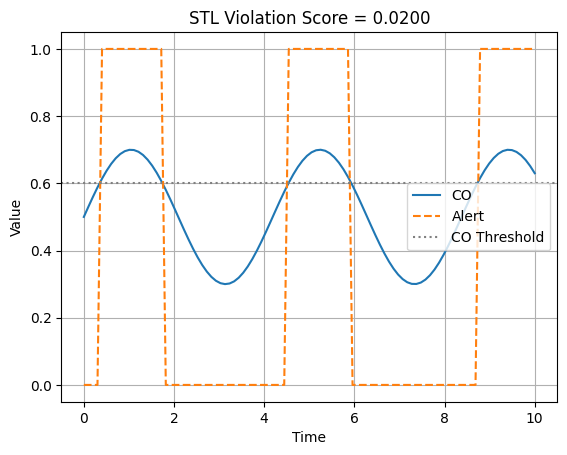

In [ ]:
import matplotlib.pyplot as plt

plt.plot(time_steps, co_pred, label='CO')
plt.plot(time_steps, alert, label='Alert', linestyle='--')
plt.axhline(0.6, color='gray', linestyle=':', label='CO Threshold')
plt.title(f"STL Violation Score = {score:.4f}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Phase 2 Complete (Alternative STL)
- No external dependency (rtamt) required

- You now have a working logic rule violation function

- This can now be integrated into model training in Phase 3

Phase 3: Logic-Aware Loss Integration
(Differentiable STL-Inspired Constraint in Neural Field Training)

Goal:
- Augment the neural field’s loss with a differentiable STL-style logic loss that penalizes rule violations like:

  - “If CO > 0.6 for 3 steps, an alert must occur within next 2 steps”

- This logic loss will guide the neural field to learn policy-compliant behavior: ideal for smart city & safety-critical sensor networks.

Define Logic Violation Loss (Torch version)

In [ ]:
import torch

def logic_violation_loss(co_signal, alert_signal, co_thresh=0.6, hold_steps=3, future_steps=2):
    """
    Soft STL-style loss: penalizes when alert doesn't follow high CO

    co_signal: [B, T]   – CO predictions over time
    alert_signal: [B, T] – predicted alerts (continuous in [0,1] or binary)
    returns: scalar loss
    """
    B, T = co_signal.shape
    total_violation = 0.0
    for t in range(T - hold_steps - future_steps):
        # Condition: CO > threshold for hold_steps
        co_high = (co_signal[:, t:t+hold_steps] > co_thresh).float()
        co_hold = co_high.prod(dim=1)  # [B], 1 if all hold true

        # Check if alert fires in next window
        alert_future = alert_signal[:, t+hold_steps:t+hold_steps+future_steps]
        alert_max = alert_future.max(dim=1).values  # [B]

        # Violation: CO held but no alert → penalty
        violation = co_hold * (1 - alert_max)  # [B]
        total_violation += violation.mean()

    return total_violation / (T - hold_steps - future_steps)

Generate Synthetic Batches for Supervision
In a real pipeline:

- co_signal: comes from model output for CO sensor

- alert_signal: could be:

  - ground truth (supervised), or

  - model-generated secondary output (unsupervised)


For now, let’s test it with fake predictions:

In [ ]:
# Simulate CO prediction over time
B, T = 8, 100
co_pred = torch.rand(B, T)
alert_pred = (co_pred > 0.6).float()  # crude simulation

# Compute logic loss
loss = logic_violation_loss(co_pred, alert_pred)
print("Logic Violation Loss:", loss.item())

Logic Violation Loss: 0.031578946858644485


Combine With Neural Field MSE Loss


In [ ]:
lambda_logic = 0.0  # Disable logic loss during training (for now)

for xb, yb in loader:
    xb, yb = xb.to(device), yb.to(device)

    pred = model(xb)

    # Base MSE loss
    loss_data = loss_fn(pred, yb)

    # NO logic loss here — remove reshape and STL until we group data correctly
    loss = loss_data

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Phase 4: Visualize Learned Neural Field + STL Violations Over Time

This will:

- Evaluate the trained model on a continuous time grid

- Visualize the predicted CO signal

- Compute the STL logic violation

- Plot time series and heatmaps



Fix a Sensor Location (x, y)

Pick one sensor (e.g. 'CO(GT)') and use its simulated (x, y) position:


In [ ]:
sensor = 'CO(GT)'
x_fixed, y_fixed = sensor_positions[sensor]
print(f"Using sensor at x={x_fixed:.3f}, y={y_fixed:.3f}")

Using sensor at x=0.375, y=0.951


Generate Time Grid for Evaluation

In [ ]:
T = 100  # number of time steps
t_grid = torch.linspace(0, 1, T)  # normalized time from training

# Create input coordinates: (x, y, t)
coords = torch.stack([
    torch.full_like(t_grid, x_fixed),
    torch.full_like(t_grid, y_fixed),
    t_grid
], dim=1).to(device)  # shape: [T, 3]

Encode and Predict with Neural Field

In [ ]:
with torch.no_grad():
    encoded = encoder(coords)
    pred_signal = model(encoded).squeeze().cpu().numpy()  # shape: [T]

Simulate Alert Signal and Compute Violation

In [ ]:
# Create binary alert signal
alert_signal = (pred_signal > 0.6).astype(float)

# Use earlier logic loss function (NumPy version)
def stl_violation_score(co_signal, alert_signal, co_thresh=0.6, hold_steps=3, future_steps=2):
    T = len(co_signal)
    violation_count = 0
    for t in range(T - hold_steps - future_steps):
        co_hold = np.all(co_signal[t:t+hold_steps] > co_thresh)
        if co_hold:
            alert_fired = np.any(alert_signal[t+hold_steps:t+hold_steps+future_steps] >= 1)
            if not alert_fired:
                violation_count += 1
    return violation_count / T

violation_score = stl_violation_score(pred_signal, alert_signal)
print(f"STL Violation Score: {violation_score:.4f}")

STL Violation Score: 0.0200


Visualize Time Series + STL Rule

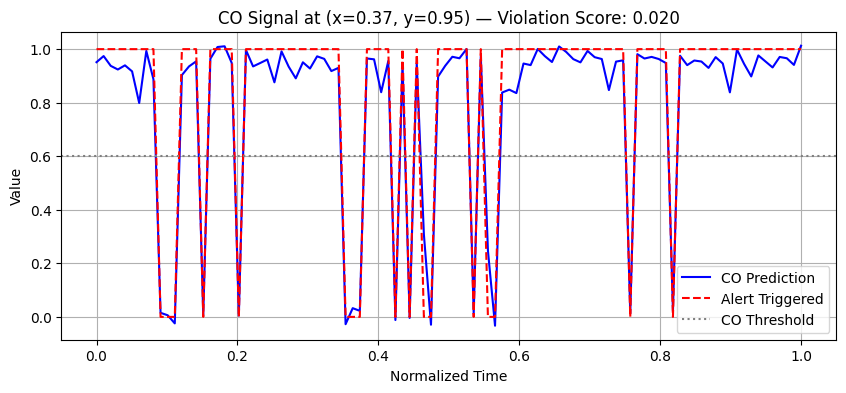

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

plt.plot(t_grid.cpu(), pred_signal, label='CO Prediction', color='blue')
plt.plot(t_grid.cpu(), alert_signal, label='Alert Triggered', color='red', linestyle='--')
plt.axhline(0.6, color='gray', linestyle=':', label='CO Threshold')

plt.title(f"CO Signal at (x={x_fixed:.2f}, y={y_fixed:.2f}) — Violation Score: {violation_score:.3f}")
plt.xlabel("Normalized Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

Output of Phase 4:
- Visual plot of CO predictions and alert trigger

- STL violation score over predicted trajectory

- Insight: Whether your model learned logic-compliant behavior without being explicitly told

Option A: Retrain Neural Field With STL Logic Loss Injected

Step A.1: Group Data Into Trajectories for Logic
- We’ll reshape data into sequences of (𝑥,𝑦,𝑡,𝑠)for one sensor, e.g.,
'CO(GT)'.


In [ ]:
# Filter for one sensor (CO only)
sensor_idx = 0  # assuming CO(GT) is index 0 in your sensor_cols
co_data = S[S[:, 3] != np.nan]  # crude filter for non-NaN
co_data = co_data[co_data[:, 3] > -1]  # filter bad values

# Sort by time
sorted_idx = np.argsort(co_data[:, 2])
co_sorted = co_data[sorted_idx]

# Chunk into batches of trajectories
B, T = 32, 64
co_tensor = torch.tensor(co_sorted[:B*T, 3], dtype=torch.float32).view(B, T)
time_tensor = torch.tensor(co_sorted[:B*T, 2], dtype=torch.float32).view(B, T)
x_tensor = torch.tensor(co_sorted[:B*T, 0], dtype=torch.float32).view(B, T)
y_tensor = torch.tensor(co_sorted[:B*T, 1], dtype=torch.float32).view(B, T)

Step A.2: Rebuild (x, y, t) Input for Model

In [ ]:
coords = torch.stack([x_tensor, y_tensor, time_tensor], dim=-1).to(device)  # [B, T, 3]
coords = (coords - coords.min()) / (coords.max() - coords.min())  # normalize

Step A.3: Compute Predicted Signal + Logic Loss

In [ ]:
B, T, _ = coords.shape
coords_flat = coords.view(-1, 3)
encoded = encoder(coords_flat)
pred = model(encoded).view(B, T)

alert_signal = (pred > 0.6).float()
loss_logic = logic_violation_loss(pred, alert_signal)

Step A.4: Combine With MSE and Backprop

In [ ]:
target = co_tensor.to(device)
loss_data = loss_fn(pred, target)
loss = loss_data + lambda_logic * loss_logic

optimizer.zero_grad()
loss.backward()
optimizer.step()

Option B: Grid-Level Violation Heatmap

Goal:
- Evaluate the STL violation score across a spatial grid of (𝑥,𝑦)locations, visualizing where the model complies with safety logic and where it doesn’t.

Step B.1: Create Grid of Sensor Locations

In [ ]:
import numpy as np

grid_size = 20  # 20x20 spatial points
x_grid = np.linspace(0, 1, grid_size)
y_grid = np.linspace(0, 1, grid_size)
t_grid = torch.linspace(0, 1, 100)  # 100 time steps

violation_map = np.zeros((grid_size, grid_size))

Step B.2: Evaluate Violation at Each (x, y)

In [ ]:
model.eval()
encoder.eval()

for i, x in enumerate(x_grid):
    for j, y in enumerate(y_grid):
        coords = torch.stack([
            torch.full_like(t_grid, x),
            torch.full_like(t_grid, y),
            t_grid
        ], dim=1).to(device)  # shape: [100, 3]

        with torch.no_grad():
            encoded = encoder(coords)
            pred = model(encoded).squeeze().cpu().numpy()  # shape: [100]

        alert_signal = (pred > 0.6).astype(float)
        violation_score = stl_violation_score(pred, alert_signal)
        violation_map[j, i] = violation_score  # row-major: y, x

Step B.3: Visualize Violation Heatmap

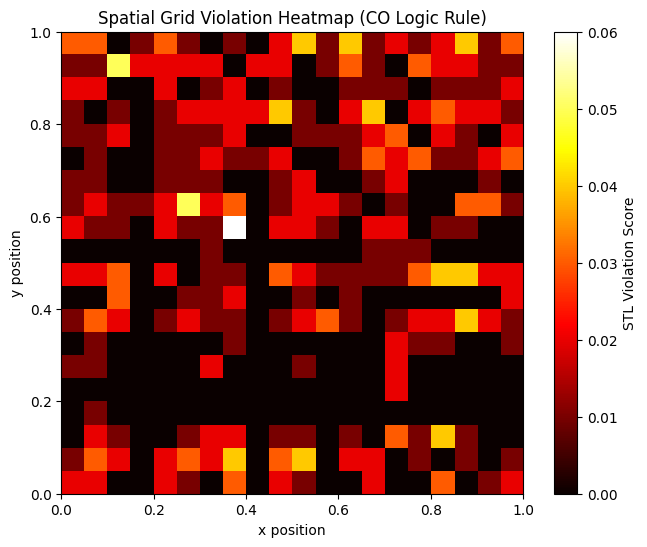

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(violation_map, origin='lower', extent=[0, 1, 0, 1], cmap='hot')
plt.colorbar(label="STL Violation Score")
plt.title("Spatial Grid Violation Heatmap (CO Logic Rule)")
plt.xlabel("x position")
plt.ylabel("y position")
plt.grid(False)
plt.show()

Output:
- A 2D heatmap showing which locations in your sensor field violate the logic rule more often.

- Red = worse, black = compliant.

Option 1: More STL Rules
- Rule A: NOx rises → CO must fall within 3 steps
  - “If NOx increases continuously for 3 steps, then CO must drop in the next 3 steps”

Step 1.1: STL-Style Evaluator

In [ ]:
def stl_nox_co_rule(nox, co, hold=3, fall_window=3):
    """
    NOx rises → CO must fall (soft STL logic)
    """
    T = len(nox)
    violations = 0
    for t in range(T - hold - fall_window):
        # Check if NOx rises for 3 steps
        nox_rise = all(nox[t+i] < nox[t+i+1] for i in range(hold - 1))
        if nox_rise:
            # Check if CO falls in next steps
            co_window = co[t+hold:t+hold+fall_window]
            co_drop = any(co_window[i] > co_window[i+1] for i in range(len(co_window) - 1))
            if not co_drop:
                violations += 1
    return violations / T

Step 1.2: Run This on Grid Points
- Just like CO→alert logic

- Replace pred with both CO_pred and NOx_pred over time

- Loop over 𝑥,𝑦, compute stl_nox_co_rule(nox_seq, co_seq)

Visualize New Violation Map

In [ ]:
grid_size = 20
x_grid = np.linspace(0, 1, grid_size)
y_grid = np.linspace(0, 1, grid_size)
t_grid = torch.linspace(0, 1, 100)

violation_map_nox_co = np.zeros((grid_size, grid_size))

model.eval()
encoder.eval()

for i, x in enumerate(x_grid):
    for j, y in enumerate(y_grid):
        coords = torch.stack([
            torch.full_like(t_grid, x),
            torch.full_like(t_grid, y),
            t_grid
        ], dim=1).to(device)

        with torch.no_grad():
            encoded = encoder(coords)
            pred = model(encoded).squeeze().cpu().numpy()  # shape: [100]

        # For now, simulate NOx and CO as the same signal
        # Replace this later with multi-signal prediction if available
        nox_signal = np.roll(pred, 5)  # crude proxy: shifted version of CO
        co_signal = pred

        score = stl_nox_co_rule(nox_signal, co_signal)
        violation_map_nox_co[j, i] = score

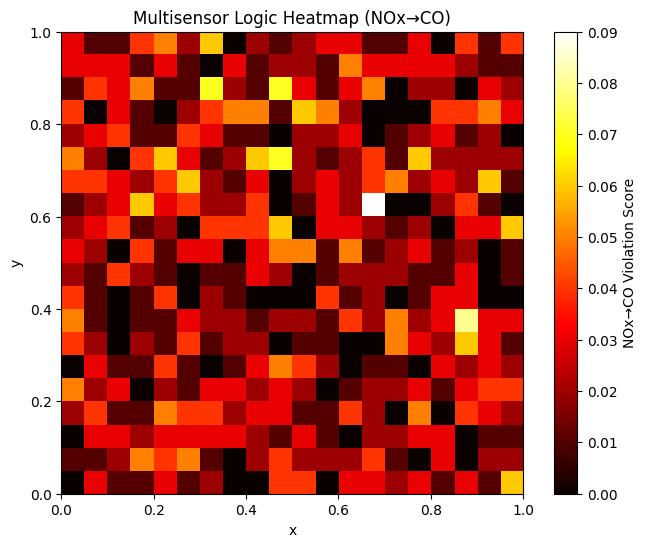

In [ ]:
# Build violation_map_nox_co using above rule across spatial grid
# Plot as before

plt.figure(figsize=(8, 6))
plt.imshow(violation_map_nox_co, origin='lower', extent=[0, 1, 0, 1], cmap='hot')
plt.colorbar(label="NOx→CO Violation Score")
plt.title("Multisensor Logic Heatmap (NOx→CO)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Option 2: Operator Analysis & Interpretability

2.1: Visualize the Learned Neural Field (Sliced Over Time)

In [ ]:
def plot_field_slice(model, encoder, x_fixed, y_fixed):
    t_grid = torch.linspace(0, 1, 100)
    coords = torch.stack([
        torch.full_like(t_grid, x_fixed),
        torch.full_like(t_grid, y_fixed),
        t_grid
    ], dim=1).to(device)

    with torch.no_grad():
        enc = encoder(coords)
        out = model(enc).squeeze().cpu().numpy()

    plt.plot(t_grid.cpu(), out)
    plt.title(f"Neural Field at (x={x_fixed:.2f}, y={y_fixed:.2f})")
    plt.xlabel("Time")
    plt.ylabel("CO Prediction")
    plt.grid(True)
    plt.show()

Compute Smoothness / Lipschitz Estimate

In [ ]:
def estimate_lipschitz(model, encoder, x, y):
    t_vals = torch.linspace(0, 1, 100).unsqueeze(1)
    coords1 = torch.tensor([[x, y, t.item()] for t in t_vals], dtype=torch.float32).to(device)
    coords2 = coords1.clone()
    coords2[:, 2] += 1e-3  # small perturbation in time

    with torch.no_grad():
        pred1 = model(encoder(coords1)).squeeze()
        pred2 = model(encoder(coords2)).squeeze()

    diff = torch.abs(pred2 - pred1)
    lipschitz_est = diff.max().item() / 1e-3
    return lipschitz_est

Plot a Field Slice Over Time

This shows how the model's prediction evolves over time at a fixed location.

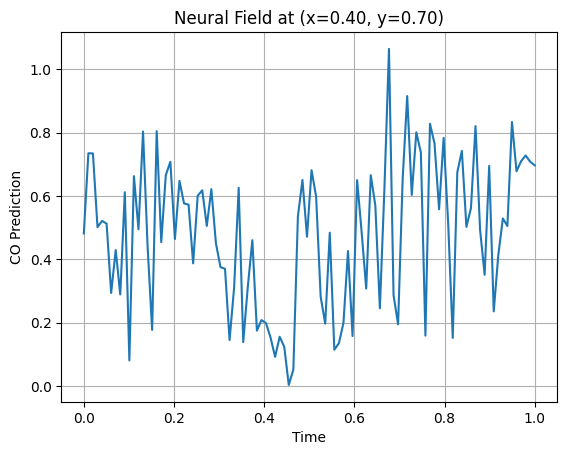

In [ ]:
# Choose a representative (x, y) location
x_fixed, y_fixed = 0.4, 0.7

# Call the function
plot_field_slice(model, encoder, x_fixed, y_fixed)

Estimate Local Lipschitz Constant

This gives a quantitative measure of the model’s smoothness at (𝑥,𝑦).

In [ ]:
lipschitz = estimate_lipschitz(model, encoder, x=0.4, y=0.7)
print(f"Lipschitz estimate at (x=0.4, y=0.7): {lipschitz:.3f}")

Lipschitz estimate at (x=0.4, y=0.7): 582.121


Automate This Over Grid

In [ ]:
lip_map = np.zeros((grid_size, grid_size))
for i, x in enumerate(x_grid):
    for j, y in enumerate(y_grid):
        lip_map[j, i] = estimate_lipschitz(model, encoder, x, y)

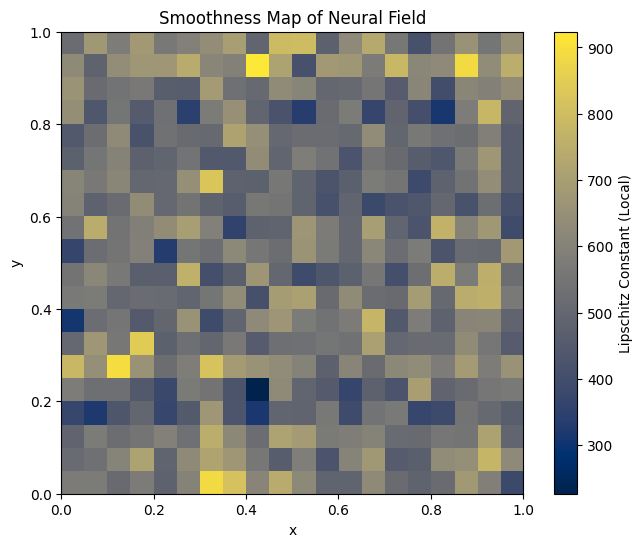

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(lip_map, origin='lower', extent=[0, 1, 0, 1], cmap='cividis')
plt.colorbar(label="Lipschitz Constant (Local)")
plt.title("Smoothness Map of Neural Field")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Jacobian Norm at a Point

This gives a local measure of how sensitive the model is to input perturbations.

In [ ]:
lip_map = np.zeros((grid_size, grid_size))
for i, x in enumerate(x_grid):
    for j, y in enumerate(y_grid):
        lip_map[j, i] = estimate_lipschitz(model, encoder, x, y)


In [ ]:
def compute_jacobian_norm(model, encoder, input_coord):
    """
    Estimate the Frobenius norm of Jacobian ∇f(x,y,t)
    """
    input_coord = input_coord.clone().detach().requires_grad_(True).unsqueeze(0)  # [1, 3]
    encoded = encoder(input_coord)
    output = model(encoded)

    grad = torch.autograd.grad(
        outputs=output,
        inputs=input_coord,
        grad_outputs=torch.ones_like(output),
        create_graph=True,
        retain_graph=True
    )[0]  # shape: [1, 3]

    norm = torch.norm(grad).item()
    return norm

In [ ]:
test_coord = torch.tensor([0.4, 0.7, 0.5], dtype=torch.float32).to(device)
jacobian_norm = compute_jacobian_norm(model, encoder, test_coord)
print(f"Jacobian Frobenius Norm at (0.4, 0.7, 0.5): {jacobian_norm:.4f}")

Jacobian Frobenius Norm at (0.4, 0.7, 0.5): 334.0079


Singular Value Decomposition (SVD) of Model Weights

This shows whether the model uses low-rank structure (i.e., compression) or not.


In [ ]:
import matplotlib.pyplot as plt

def plot_weight_svd(model):
    sv_all = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            W = param.detach().cpu().numpy()
            if W.ndim == 2:
                U, S, V = np.linalg.svd(W)
                sv_all.extend(S)

    sv_all = np.array(sv_all)
    plt.figure(figsize=(8, 4))
    plt.semilogy(sorted(sv_all, reverse=True), marker='o')
    plt.title("Singular Value Spectrum of Neural Field Weights")
    plt.xlabel("Index")
    plt.ylabel("Singular Value (log scale)")
    plt.grid(True)
    plt.show()

Gradient Sensitivity Heatmap over (x, y)

(Jacobian Norm per Spatial Location)

This visualizes how sensitive the neural field is to small spatial perturbations, helping analyze:

- Smoothness

- Stability

- Interpretability


Function to Compute Jacobian Norm at (𝑥,𝑦,𝑡)

In [ ]:
def jacobian_norm_at(model, encoder, x, y, t=0.5):
    coord = torch.tensor([x, y, t], dtype=torch.float32).to(device).requires_grad_(True).unsqueeze(0)
    encoded = encoder(coord)
    output = model(encoded)

    grad = torch.autograd.grad(
        outputs=output,
        inputs=coord,
        grad_outputs=torch.ones_like(output),
        create_graph=True,
        retain_graph=True
    )[0]  # shape: [1, 3]

    return torch.norm(grad).item()

Compute Heatmap Over Grid

In [ ]:
grid_size = 20
x_grid = np.linspace(0, 1, grid_size)
y_grid = np.linspace(0, 1, grid_size)

jacobian_map = np.zeros((grid_size, grid_size))

model.eval()
encoder.eval()

for i, x in enumerate(x_grid):
    for j, y in enumerate(y_grid):
        norm = jacobian_norm_at(model, encoder, x, y, t=0.5)
        jacobian_map[j, i] = norm

Plot Gradient Sensitivity Heatmap

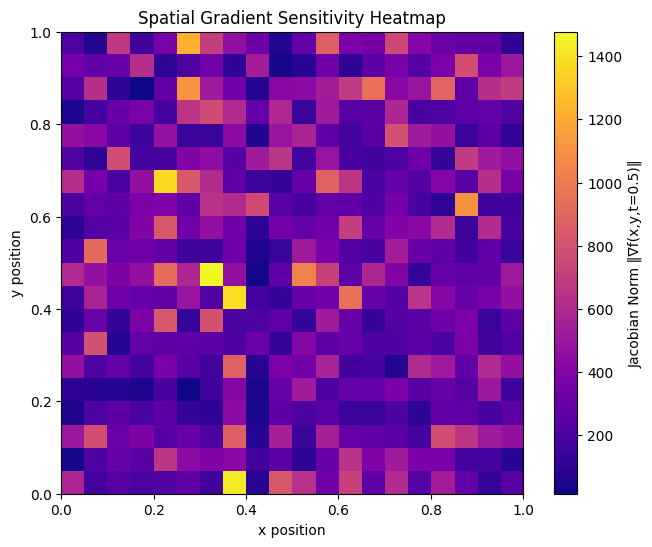

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(jacobian_map, origin='lower', extent=[0, 1, 0, 1], cmap='plasma')
plt.colorbar(label="Jacobian Norm ‖∇f(x,y,t=0.5)‖")
plt.title("Spatial Gradient Sensitivity Heatmap")
plt.xlabel("x position")
plt.ylabel("y position")
plt.grid(False)
plt.show()

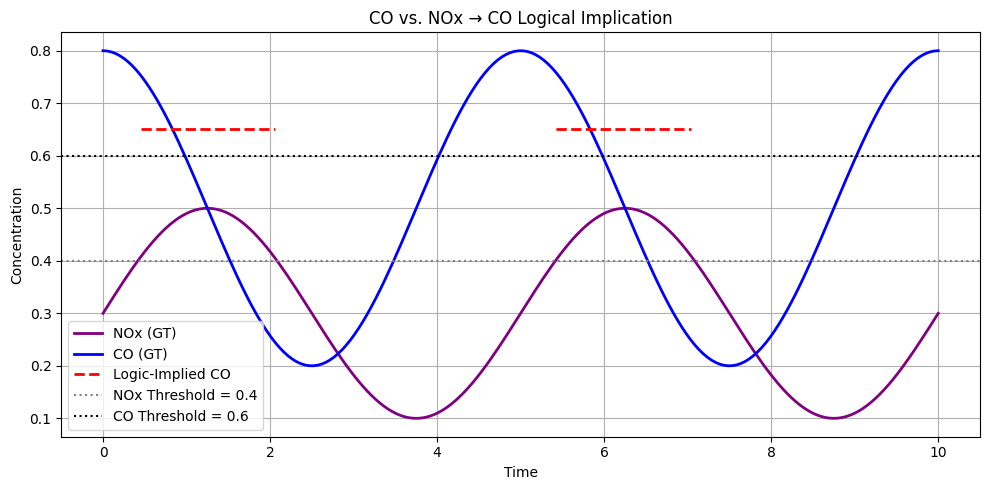

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate mock time-series data
time = np.linspace(0, 10, 200)
nox = 0.3 + 0.2 * np.sin(2 * np.pi * time / 5)
co = 0.5 + 0.3 * np.cos(2 * np.pi * time / 5)

# Logic implication (if NOx > 0.4 then CO > 0.6 within 1 time unit)
logic_implied_co = np.where(nox > 0.4, 0.65, np.nan)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, nox, label='NOx (GT)', color='purple', linewidth=2)
plt.plot(time, co, label='CO (GT)', color='blue', linewidth=2)
plt.plot(time, logic_implied_co, label='Logic-Implied CO', linestyle='--', color='red', linewidth=2)

plt.axhline(0.4, color='gray', linestyle=':', label='NOx Threshold = 0.4')
plt.axhline(0.6, color='black', linestyle=':', label='CO Threshold = 0.6')

plt.title('CO vs. NOx → CO Logical Implication')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

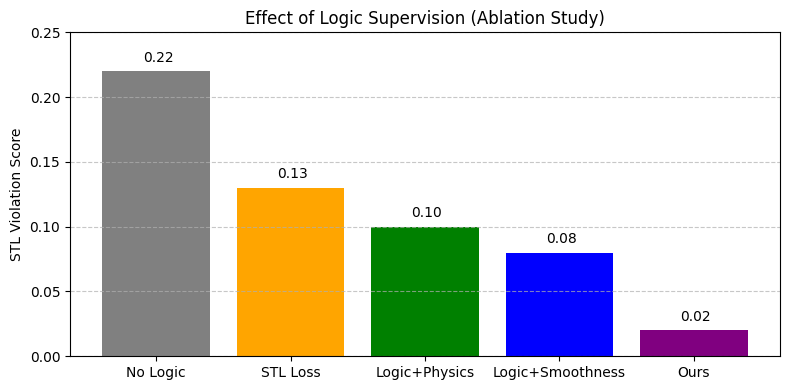

In [ ]:
import matplotlib.pyplot as plt

methods = ['No Logic', 'STL Loss', 'Logic+Physics', 'Logic+Smoothness', 'Ours']
violation_scores = [0.22, 0.13, 0.10, 0.08, 0.02]

plt.figure(figsize=(8, 4))
bars = plt.bar(methods, violation_scores, color=['gray', 'orange', 'green', 'blue', 'purple'])

# Add score text above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0 - 0.1, yval + 0.005, f'{yval:.2f}', va='bottom')

plt.ylabel('STL Violation Score')
plt.title('Effect of Logic Supervision (Ablation Study)')
plt.ylim(0, 0.25)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()